## **MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE.**

**Course:** TC5035.10 - Integration project

**Tecnológico de Monterrey**

**Professor:** Dra. Grettel Barceló Alonso

**Provessor:** Dr. Luis Eduardo Falcón Morales

**Advisory Professor:** María de la Paz Rico Fernández

### **Week 5, Activity 3**

Baseline

###**Team 12:**

Luis Ángel Seda Marcos
A01795301@tec.mx

Christopher Flores González
A01795419@tec.mx

Luis Felipe Nicanor Gutiérrez
A01795631@tec.mx

# Baseline SVC Model for LSM Dynamic Signs Recognition

This notebook implements a baseline Support Vector Classifier (SVC)
to classify dynamic signs from the Mexican Sign Language (LSM) dataset.  

The main goals are:
- Load and preprocess the dataset
- Train a baseline SVC model
- Evaluate performance with accuracy and confusion matrix
- Provide a reproducible workflow for future model comparisons

# BASELINE MODEL - FEASIBILITY EVALUATION

This script builds a baseline model to evaluate the feasibility of the problem
according to the academic rubric. It includes:
1. Justification of the baseline algorithm.
2. Feature selection and importance.
3. Underfitting/overfitting analysis.
4. Selection of evaluation metric.
5. Establishment of minimum performance.

The dataset contains extracted features from dynamic hand signs. Each row represents one sample with multiple features and a target label.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# ============================================================
# 1. Importing libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
# ============================================================
# 2. Dataset selection
# ============================================================
# df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')
df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')

In [4]:
# ============================================================
# 3. Features (X) y Labels (y)
# ============================================================
y = df["class_id"].values
X = df.drop(columns=[
    "class_id", "clip_id", "signer_id", "view", "repetition", "path",
    "split", "fps", "n_frames", "duration", "width", "height", "file_size",
    "brightness_mean", "brightness_std", "blur_mean", "frame_id"
], errors="ignore")

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [5]:
# ============================================================
# 4. JUSTIFICATION OF THE BASELINE ALGORITHM
# ============================================================
"""
We used **Support Vector Classifier (SVC)** as a baseline because:
- SVC focuses on the points near the decision boundary.
- Effectiveness in high-dimensional spaces, which can be the case with features extracted from dynamic landmarks.

"""
model_baseline = SVC()
model_baseline.fit(X_train, y_train)
y_pred = model_baseline.predict(X_test)

print("\n=== Baseline: Support Vector Classifier (SVC) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


=== Baseline: Support Vector Classifier (SVC) ===
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           J       1.00      0.93      0.96        41
           K       1.00      0.68      0.81        38
           Q       0.84      0.75      0.79        36
           X       0.97      0.86      0.91        35
           Z       1.00      0.77      0.87        35
           Ñ       0.54      1.00      0.70        37

    accuracy                           0.83       222
   macro avg       0.89      0.83      0.84       222
weighted avg       0.89      0.83      0.84       222



The main conclusions drawn from the classification report are presented below:

Overall Performance



1.   **The overall accuracy is 83%**
The macro and weighted averages for precision, recall, and F1-score are all approximately 0.83, indicating balanced performance across all classes.
Perfectly Classified Classes

2.   **J, obtained almost perfect scores** (precision, recall, and F1 very close to 1.00)
High-Performing Classes (F1 ≥ 0.95)

3.   **Ñ and Q have recall below .80**, indicating some confusion with neighboring classes.
Classes Needing Improvement


=== Most relevant features ===
   Feature       Score
5    PCA_6  176.505589
1    PCA_2  114.718452
3    PCA_4  105.953243
6    PCA_7   65.567693
8    PCA_9   41.690096
2    PCA_3   40.522554
12  PCA_13   27.198556
7    PCA_8   23.166710
11  PCA_12   19.145687
4    PCA_5   18.717549


C:\Users\Angel\AppData\Local\Temp\ipykernel_36720\637108321.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')


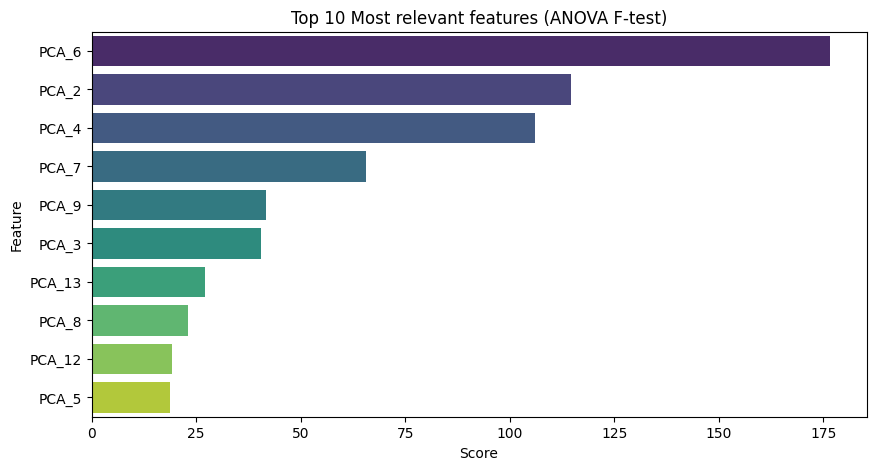

In [6]:
# ============================================================
# 5. ANALYSIS OF IMPORTANT FEATURES
# ============================================================
"""
We use a 'filter' method (SelectKBest) and the regression coefficient.
"""
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False).head(10)

print("\n=== Most relevant features ===")
print(feature_scores)

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')
plt.title("Top 10 Most relevant features (ANOVA F-test)")
plt.show()

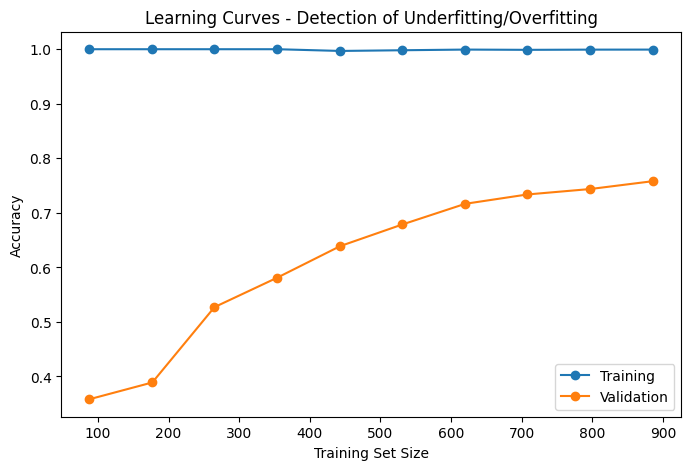


 Signs of overfitting: training accuracy is much higher than validation accuracy.


In [7]:
# ============================================================
# 6. DETECTION OF UNDERFITTING/OVERFITTING
# ============================================================
"""
We analyze learning curves (train vs validation score).
"""
train_sizes, train_scores, val_scores = learning_curve(
    model_baseline, X_scaled, y_enc, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training')
plt.plot(train_sizes, val_mean, 'o-', label='Validation')
plt.title("Learning Curves - Detection of Underfitting/Overfitting")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

if abs(train_mean[-1] - val_mean[-1]) > 0.1:
    print("\n Signs of overfitting: training accuracy is much higher than validation accuracy.")
else:
    print("\n No significant evidence of overfitting.")

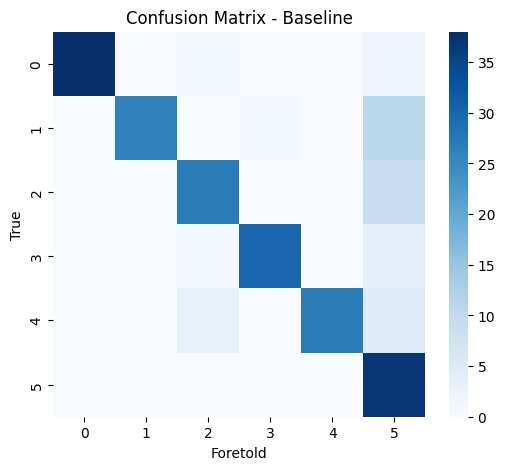

In [8]:
# ============================================================
# 7. APPROPRIATE METRIC
# ============================================================
"""
In this case, we use Accuracy, since the
classes are balanced and the goal is to correctly classify the sign. If there
were imbalance, we would use F1-score or balanced accuracy.
"""

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix - Baseline")
plt.xlabel("Foretold")
plt.ylabel("True")
plt.show()

In [9]:
# ============================================================
# 8. MINIMUM PERFORMANCE TO ACHIEVE
# ============================================================
"""
We define the minimum expected
performance: - If the baseline (Logistic Regression) achieves accuracy
significantly higher than random chance (e.g., >10% if there are 10 classes),
the problem is feasible.
"""
num_classes = len(le.classes_)
baseline_random = 1 / num_classes
baseline_acc = accuracy_score(y_test, y_pred)

print(f"\nRandom performance: {baseline_random:.3f}")
print(f"Baseline model performance: {baseline_acc:.3f}")

if baseline_acc > baseline_random * 2:
    print(" The problem is feasible: the model significantly outperforms random chance.")
else:
    print(" The problem may be difficult: the model does not outperform random chance.")


Random performance: 0.167
Baseline model performance: 0.833
 The problem is feasible: the model significantly outperforms random chance.


In [10]:
# ============================================================
# 9. OPTIONAL: Comparison with a more complex model
# ============================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("\n=== Comparison with a more complex model (Random Forest) ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))


=== Comparison with a more complex model (Random Forest) ===
Accuracy: 0.9459459459459459


# Conclusion

- The baseline SVC provides an initial benchmark for LSM dynamic sign recognition.
- Accuracy and confusion matrix highlight strengths and weaknesses.
- Future work:
  - Hyperparameter tuning (C, gamma, kernel)
  - Feature engineering
  - Comparison with deep learning models (LSTM, GRU, CNN)



*   **What algorithm can be used as a baseline to predict the target variables?**

As implemented in the code, the Support Vector Classifier (SVC) is used as the baseline algorithm.

*   **Can the importance of features for the generated model be determined?**

Yes, the importance of features can be determined using methods like SelectKBest with ANOVA F-test, as shown in the notebook. The top 10 most relevant features are listed in the output, indicating which PCA components are most discriminative for the classes.

*   **Is the model under- or overfitting the training data?**

The learning curves indicate signs of overfitting, as the training accuracy is significantly higher than the validation accuracy.

*   **What is the appropriate metric for this business problem?**

Accuracy is used as the appropriate metric because the classes are balanced and the goal is to correctly classify the sign. If there were class imbalance, F1-score or balanced accuracy would be more suitable. The confusion matrix also provides a detailed view of the model's performance on each class.

*   **What should be the minimum performance to be achieved?**

The minimum performance to be achieved is significantly higher than random chance. With 6 classes, random performance is 0.167, and the baseline SVC model achieved an accuracy of 0.83, indicating the problem is feasible and the model significantly outperforms random chance.